## Topic Modeling with LDA

In this section we develop a topic model using Latent Dirichlet Allocation (LDA) to discover unobserved themes across papers. This may have practical value in the following ways: 

1. Uncovering nontrivial relationships between disparate fields of research 
2. Organizing papers into useful categories
3. Navigating citations based on their usage in papers within & across categories 

(note: #3 is not possible with the HuggingFace dataset we are using, which omits references)

#### Part 1: Load & Preprocess Data

In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from datasets import load_dataset
from natsort import natsort_keygen

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [585]:
# Load pubmed dataset from huggingface
articles = load_dataset("scientific_papers", "pubmed", split="train")
df_articles = pd.DataFrame(articles)

Found cached dataset scientific_papers (/Users/mattroth/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [586]:
# Inspect df_articles
df_articles.head()

,article,abstract,section_names
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...


**Preprocessing:** To preprocess the text data, we first lemmatize the article text (using tokens that have all non-word characters stripped) so that words are reduced to their dictionary forms. Next, we expand the set of default english stop words with scientific terms including units of measurement (e.g., "mg, mm, m") and citation abbreviations (e.g., "et al."). After that, we vectorize the corpus with a TfidfVectorizer and extract the vocabulary.

In [587]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(
    "(?:(?<=\s)|(?<=^)|(?<=[>\"]))[a-z-']+(?:(?=\s)|(?=\:\s)|(?=$)|(?=[.!,;\"]))"
)

# Lemmatize article text
lem = WordNetLemmatizer()
def lemmatize_text(text):
    return [lem.lemmatize(w) for w in tokenizer.tokenize(text)]

# Add lemmatized version of articles to df_articles
df_articles['article_lemmatized'] = df_articles["article"].apply(lambda x: lemmatize_text(x))
df_articles["article_lemmatized"] = df_articles["article_lemmatized"].apply(lambda x: " ".join(x))

# Create custom stop words set with units and others
custom_stop_words = text.ENGLISH_STOP_WORDS.union([
    "et","al", # from et al
    "mg","g","kg","lb", # mass / weight
    "ml","l","dl","oz","mol","mmol", # volume
    "nm","mm","cm","m","ft", # length
    "c","f","j", # temperature
    "s","h","hr","ms","hz","mhz", # time / frequency 
    "p","h" # other
    ])

# Encode data with TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=list(custom_stop_words),
                        max_df=0.90, # ignore words occuring in more than this % of docs
                        min_df=0.02, # ignore words occuring in less than this % of docs
                        max_features=2000,
                        tokenizer=tokenizer.tokenize)
vectorized_articles = tfidf.fit_transform(df_articles["article_lemmatized"])

# Save vocab
vocab = tfidf.get_feature_names_out()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Step 2: Run LDA

We chose 20 topics for our LDA model because having fewer topics led to overly broad categorizations, and given the size and diversity of the training set (119,924 articles from multiple domains) it is likely that there are many latent topics. Having more than 20 topics makes it hard to interpret the groupings and use them to categorize the data.

In [588]:
# Instantiate LDA
n_topics = 20
lda = LDA(n_components=n_topics, n_jobs=-1)

# Run on vectorized_articles
X_topics = lda.fit_transform(vectorized_articles)

In [589]:
# Get topic distribution
topic_words = lda.components_

# Retrieve topics
topics_top3_words = {}
for i, topic_dist in enumerate(topic_words):
    
    # Zip vocab and topic distribution
    zipped_3 = zip(vocab, topic_dist)
    zipped_10 = zip(vocab, topic_dist)

    # Sort and get out top 3 words for each topic for dict
    top_terms_key_3 = sorted(zipped_3, key=lambda t: t[1], reverse=True)[0:3]
    top_terms_list_3 = list(dict(top_terms_key_3).keys())

    # Do again with top 10 words to print here
    top_terms_key_10 = sorted(zipped_10, key=lambda t: t[1], reverse=True)[0:10]
    top_terms_list_10 = list(dict(top_terms_key_10).keys())

    # Print
    print(f"Topic {i + 1}: {top_terms_list_10}")

    topics_top3_words[i] = f"Topic {i + 1}: {top_terms_list_3}"
    

Topic 1: ['health', 'patient', 'study', 'child', 'care', 'score', 'participant', 'group', 'student', 'service']
Topic 2: ['eye', 'retinal', 'visual', 'corneal', 'ocular', 'patient', 'optic', 'lens', 'vision', 'laser']
Topic 3: ['strain', 'isolates', 'pcr', 'sequence', 'gene', 'virus', 'dna', 'primer', 'sample', 'specie']
Topic 4: ['patient', 'day', 'case', 'renal', 'infection', 'treatment', 'disease', 'therapy', 'serum', 'blood']
Topic 5: ['tumor', 'cancer', 'patient', 'metastasis', 'carcinoma', 'breast', 'cell', 'chemotherapy', 'node', 'survival']
Topic 6: ['infection', 'hiv', 'patient', 'study', 'case', 'prevalence', 'infected', 'positive', 'disease', 'parasite']
Topic 7: ['protein', 'figure', 'structure', 'nmr', 'energy', 'binding', 'compound', 'spectrum', 'solution', 'd']
Topic 8: ['concentration', 'water', 'sample', 'solution', 'group', 'rat', 'cell', 'extract', 'acid', 'min']
Topic 9: ['data', 'gene', 'research', 'database', 'user', 'information', 'article', 'health', 'genome', '

In [590]:
# Extract top topic for all articles
article_topics = lda.transform(vectorized_articles)

topics = []
for i in range(article_topics.shape[0]):

    # Get most likely topic for each article
    topic = article_topics[i].argmax() + 1
    topics.append(topic)

# Add columns to df_articles
df_articles["main_topic"] = topics
for i in range(article_topics.shape[1]):
    df_articles[f"Topic{i+1}"] = article_topics[:,i]

# Inspect df_articles with topic
df_articles.head()    

,article,abstract,section_names,article_lemmatized,main_topic,Topic1,Topic2,Topic3,Topic4,Topic5,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...,a recent systematic analysis showed that in - ...,1,0.917036,0.004367,0.004367,0.004367,0.004367,...,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...,it occurs in more than of patient and may reac...,4,0.005436,0.005436,0.005436,0.549492,0.005436,...,0.005436,0.352652,0.005436,0.005436,0.005436,0.005436,0.005436,0.005436,0.005436,0.005436
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...,tardive dystonia td a rarer side effect after ...,4,0.314436,0.004388,0.004388,0.606584,0.004388,...,0.004388,0.004388,0.004388,0.004388,0.004388,0.004388,0.004388,0.004388,0.004388,0.004388
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...,lepidoptera include agricultural pest that thr...,16,0.004306,0.004306,0.004306,0.004306,0.004306,...,0.004306,0.004306,0.004306,0.004306,0.004306,0.918182,0.004306,0.004306,0.004306,0.004306
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...,syncope is caused by transient diffuse cerebra...,13,0.004693,0.004693,0.004693,0.004693,0.004693,...,0.004693,0.004693,0.468020,0.004693,0.447515,0.004693,0.004693,0.004693,0.004693,0.004693


#### Part 3: Topic Modeling Results & Analysis

The 20 latent topics found by the LDA model are all coherent (see "Top Words by LDA Topics") and uncorrelated with each other (see "Correlation Between Topics Within Articles"). These characteristics suggest that the model found topics that form meaningful categories without much redundancy. The topics clearly align with different areas of research (e.g., dentistry, oncology, clinical studies, optometry, etc.) 

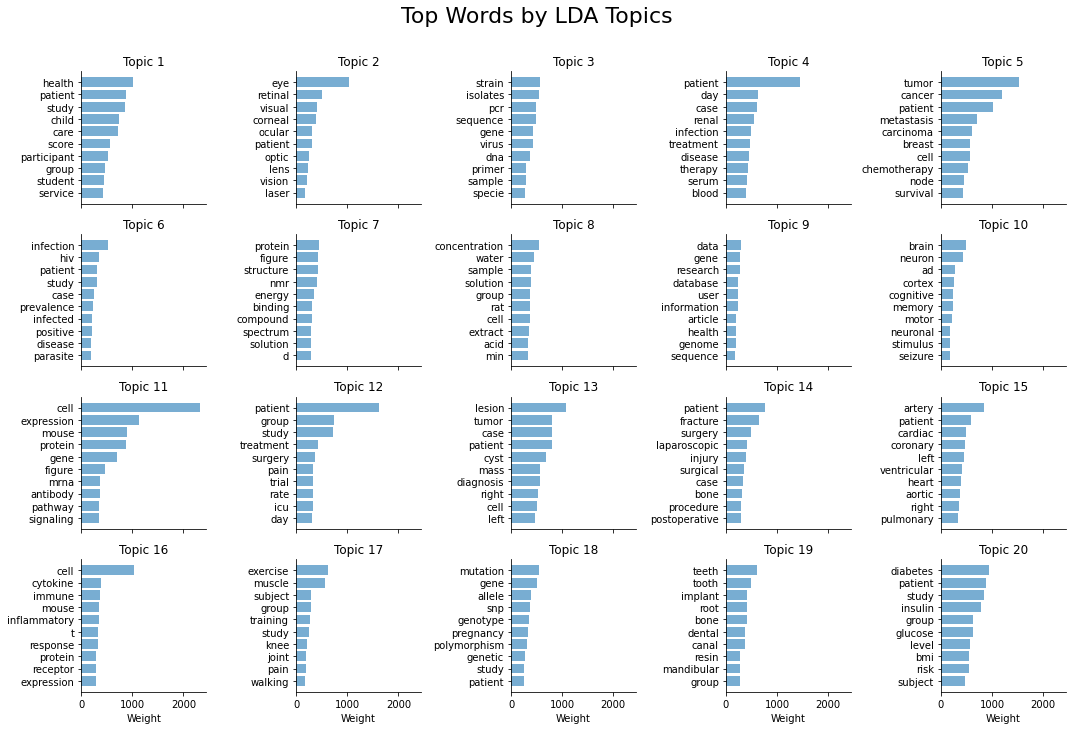

In [591]:
# Function to plot word importances to topics
def plot_top_words(model, feature_names):
    
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -10 - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, alpha=0.6)
        ax.set_title(f"Topic {topic_idx +1}")
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major")
        for i in "top right".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Top Words by LDA Topics", fontsize=22, y=1.01)
        if topic_idx >= 15:
            ax.set_xlabel("Weight")

    plt.tight_layout()
    plt.show()

plot_top_words(lda, vocab)

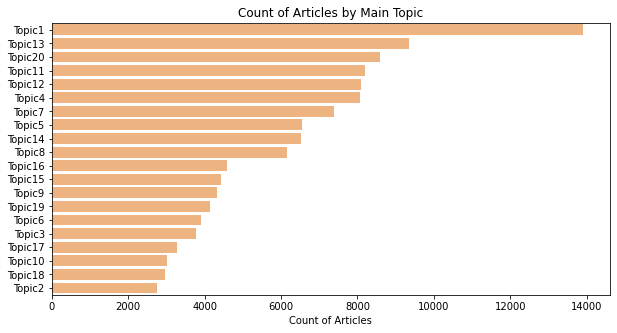

In [601]:
# Plot topics by number of articles where each topic is the main topic
topic_count = df_articles.groupby("main_topic")["article"].count().reset_index()\
    .sort_values(by="article", ascending=False)
topic_count["topic_name"] = [f"Topic{t}" for t in topic_count["main_topic"]]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=topic_count,
    y="topic_name",
    x="article",
    color="tab:orange",
    alpha=0.6
)
plt.ylabel(None)
plt.xlabel("Count of Articles")
plt.title("Count of Articles by Main Topic")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


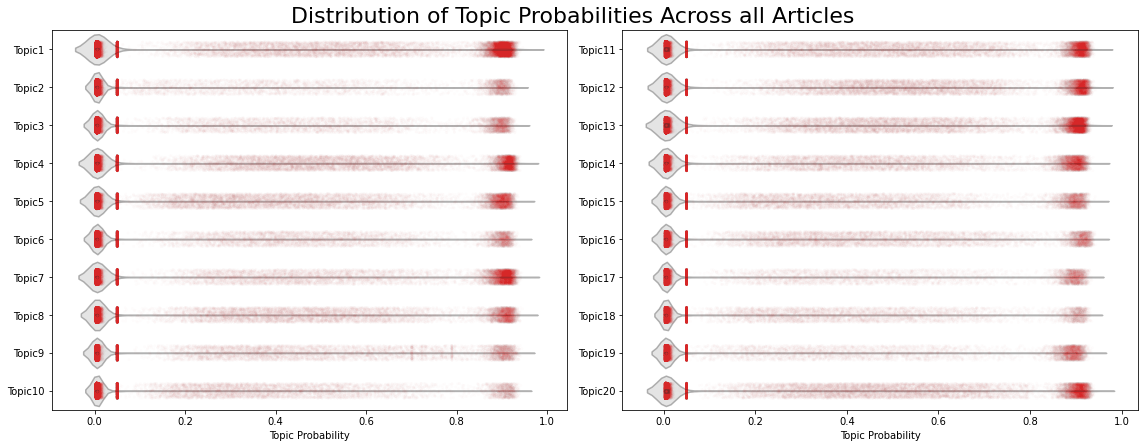

In [600]:
# Violinplot to show distribution of probabilties that each article draws from each topic

# Extract topic probability columns
topic_probs = df_articles.loc[:, "Topic1":]

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
for i in range(2):
    if i == 0:
        sns.violinplot(data=topic_probs.iloc[:,0:int(n_topics/2)], color="lightgray", orient='h', ax=axs[i])
        plt.setp(axs[i].collections, alpha=.6)
        sns.stripplot(
            data=topic_probs.iloc[:,0:int(n_topics/2)], color="tab:red", alpha=0.01, size=3, orient='h', jitter=0.2, ax=axs[i])
        axs[i].set_xlabel("Topic Probability")
    else:
        sns.violinplot(data=topic_probs.iloc[:, int(n_topics/2):], color="lightgray", orient='h', ax=axs[i])
        plt.setp(axs[i].collections, alpha=.6)
        sns.stripplot(
            data=topic_probs.iloc[:, int(n_topics/2):], color="tab:red", alpha=0.01, size=3, orient='h', jitter=0.2, ax=axs[i])
        axs[i].set_xlabel("Topic Probability")
plt.tight_layout()
plt.suptitle("Distribution of Topic Probabilities Across all Articles", fontsize=22, y=1.03)
plt.show()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55010/3541034564.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(topic_correlations, dtype=np.bool))


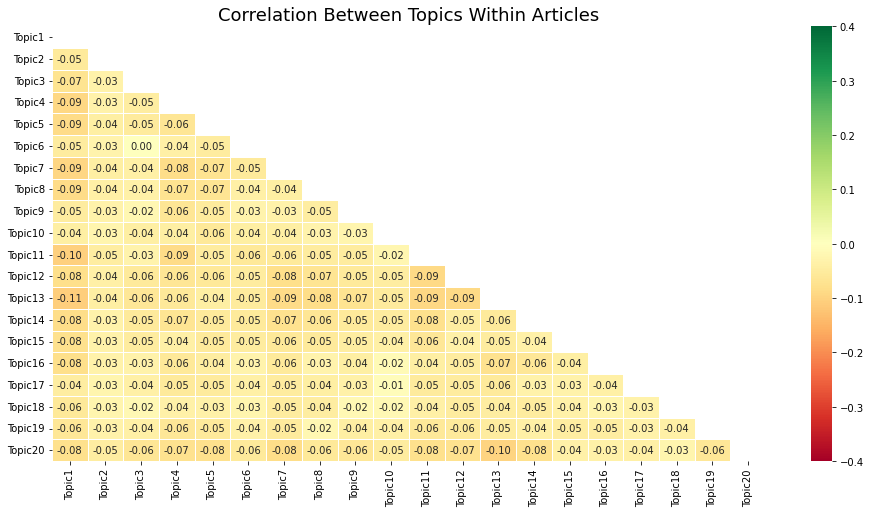

In [594]:
# Visualize correltion between topics
topic_correlations = df_articles.loc[:, "Topic1":].corr()
fig, ax = plt.subplots(figsize=(16,8))
mask = np.triu(np.ones_like(topic_correlations, dtype=np.bool))
sns.heatmap(
    topic_correlations,
    annot=True,
    fmt=".2f",
    mask=mask,
    vmin=-0.4,
    vmax=0.4,
    cmap="RdYlGn",
    linewidth=1
    )
plt.title("Correlation Between Topics Within Articles", fontsize=18)
plt.show()

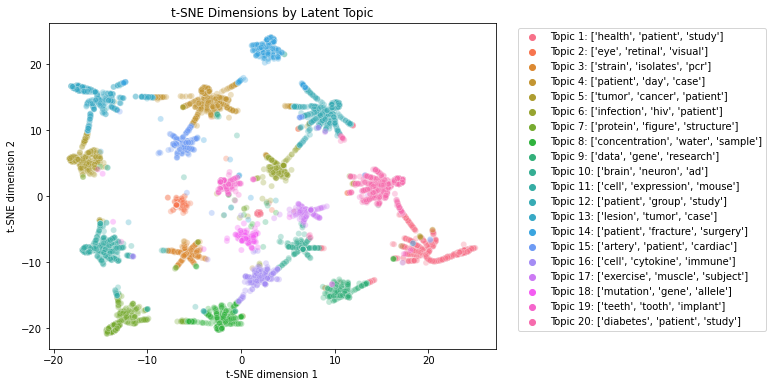

In [597]:
# Visualize topic distributions with t-SNE on 10% random sample
tsne = TSNE(perplexity=500, early_exaggeration=100)
article_topics_sample = article_topics[np.random.choice(article_topics.shape[0], 
                                         article_topics.shape[0] // 10, 
                                         replace=False)]
tsne_results = tsne.fit_transform(article_topics_sample)
embedding = pd.DataFrame(tsne_results, columns=['x','y'])
embedding["main_topic"] = [topics_top3_words[t] for t in article_topics_sample.argmax(axis=1)]
embedding.sort_values("main_topic", ascending=True, key=natsort_keygen(), inplace=True)

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=embedding,
    x="x", 
    y="y",
    hue="main_topic",
    palette=sns.color_palette("husl", embedding["main_topic"].nunique()),    
    legend="full",
    alpha=0.3
)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE Dimensions by Latent Topic")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


#### Future Directions

**LDA on New Articles:** Now that our topic model is trained on a large corpus of pubmed articles, new articles can be classified and their topic mixtures can be analyzed.

**LDA on OSCAR Summaries:** Here, our topic model was run on full article text, but we could also run it on the summarized outputs from OSCAR. This might lead to different, higher-level groupings that may add value when combined with granular topics from LDA run on the full-text. 

**Network Analysis:** Given a dataset that includes citations, a network analysis could be performed to see which papers and authors are cited most within topics and which bridge across topics. This could help researchers find papers that might be relevant to their work or connect with other researchers working on related problems. 

**Hyperparameter Tuning:** While we performed some hyperparameter tuning in this analysis, more work could be done to improve our model. For example, we could try a range of values for the number of topics and evaluate the results based on coherence score, perplexity, or loss. We could also optimize our text preprocessing by using different stop words, lemmatizers, and TF-IDF hyperparamters (e.g., more features). 